In [1]:
import os
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

from IPython.display import Image, display, SVG, clear_output, HTML

import skimage.io
import torch_geometric.data
import torch_geometric.utils 

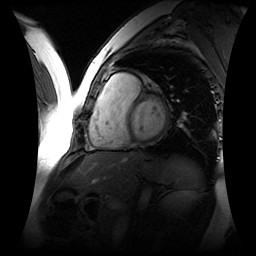

In [2]:
image_file = "data/train/images/image_0001.png"
image = skimage.io.imread(image_file)
display(Image(image_file))

In [3]:
class ImageGrid(object):
    def __init__(self, array=None, diff_edge=False):
        self.reset()
        self.set_array(array, diff_edge=diff_edge)

    def reset(self):
        self.height = 0
        self.width = 0
        self.array = None
        self.graph = None

    def set_array(self, array, diff_edge=False):
        self.reset()
        self.array = array
        height, width = array.shape[:2]
        self.set_shape(height, width)

        # Create the graph
        self.graph = nx.grid_2d_graph(self.height, self.width)
        self.set_nodes(weight=None)
        self.set_edges(weight=None, diff_edge=diff_edge)
        return self.graph

    # def set_image(self, image):
    #     return self.set_array(image, diff_edge=False)
    
    # def set_label(self, label):
    #     return self.set_array(label, diff_edge=True)
    
    def set_shape(self, height, width):
        self.height = height
        self.width = width

    def set_edges(self, weight=None, diff_edge=True):
        for e, edge in enumerate(self.graph.edges):
            self.graph.edges[edge]['weight'] = 0.5

        self.graph.add_edges_from([
            ((x, y), (x+1, y+1))
            for x in range(self.width-1)
            for y in range(self.height-1)
        ] + [
            ((x+1, y), (x, y+1))
            for x in range(self.width-1)
            for y in range(self.height-1)
        ], weight=0.5)

        if diff_edge:
            for e, edge in enumerate(self.graph.edges):
                self.graph.edges[edge]['weight'] = abs(self.array[edge[0]] - self.array[edge[1]]) 

    def set_nodes(self, weight=None):
        for n, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['weight'] = self.array.flatten()[n] if weight is None else weight

image_grid = ImageGrid(array=image[:3, :3].copy())
print(len(image_grid.graph.nodes))
print(len(image_grid.graph.edges))

G = image_grid.graph
data = torch_geometric.utils.from_networkx(G, 
    group_node_attrs=['weight'],
    group_edge_attrs=['weight'])
data

9
20


Data(edge_index=[2, 40], x=[9, 1], edge_attr=[40, 1])